# This notebook demonstrates plotting seaonal mean MCS rain and track statistics on maps without plotting their difference
## The OBS and model data can be on different grids
## The monthly data is produced by: 
* /Analysis/calc_tbpf_mcs_monthly_rainmap.py
* /Analysis/calc_tbpf_mcs_monthly_statsmap.py

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
import colorcet as cc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from itertools import chain
import copy
%matplotlib inline

In [2]:
# Sepcify directory of the MCS track stats file
rootdir = '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/'
obsdir = f'{rootdir}OBS/stats/monthly/'
wrfdir = f'{rootdir}WRF/stats/monthly/'

start_year = 2004
end_year = 2016

# Create a list of dates in the format 'year-months'
dates = []
for iy in range(start_year, end_year+1, 1):
    dates = dates + [d.strftime('%Y%m') for d in pd.date_range(start=f'{iy}-01', end=f'{iy}-12', freq='MS')]

# Find all files from the list of dates
obsfiles = []
wrffiles = []

wrfstatsfiles = []
obsstatsfiles = []
for dd in dates:
    wrffiles = wrffiles + sorted(glob.glob(f'{wrfdir}mcs_rainmap_{dd}*.nc'))
    obsfiles = obsfiles + sorted(glob.glob(f'{obsdir}mcs_rainmap_{dd}*.nc'))
    wrfstatsfiles = wrfstatsfiles + sorted(glob.glob(f'{wrfdir}mcs_statsmap_{dd}*.nc'))
    obsstatsfiles = obsstatsfiles + sorted(glob.glob(f'{obsdir}mcs_statsmap_{dd}*.nc'))

nyears_obs = 13
nyears_wrf = 13
    
# topfile = '/global/project/projectdirs/m1657/zfeng/SAAG/map_data/wrf_landmask_reg2imerg.nc'

figdir = f'/global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/


In [3]:
print(f'OBS: number of rainmap files: {len(obsfiles)}, number of statsmap files {len(obsstatsfiles)}')

OBS: number of rainmap files: 104, number of statsmap files 104


In [4]:
print(f'WRF: number of rainmap files: {len(wrffiles)}, number of statsmap files {len(wrfstatsfiles)}')

WRF: number of rainmap files: 104, number of statsmap files 104


# These customed functions enables use of [NCL colormaps](https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml)

In [5]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [6]:
# # Read topography data
# dstop = xr.open_dataset(topfile)
# # Convert surface geopotential to height in meters
# ter = dstop.HGT.squeeze()
# landmask = dstop.LANDMASK.squeeze()
# ter_s = gaussian_filter(ter, 1)
# lon_ter = dstop.lon
# lat_ter = dstop.lat
# dstop

In [7]:
# Read WRF rain map files
dswrf = xr.open_mfdataset(wrffiles, concat_dim='time', combine='nested')
lon_wrf = dswrf.longitude.isel(time=0).load().data
lat_wrf = dswrf.latitude.isel(time=0).load().data
dswrf.load()

<xarray.Dataset>
Dimensions:                  (time: 104, lat: 299, lon: 424)
Coordinates:
  * time                     (time) datetime64[ns] 2004-03-01 ... 2016-10-01
  * lat                      (lat) float32 21.05 21.15 21.25 ... 51.41 51.51
  * lon                      (lon) float32 -121.0 -120.9 ... -73.14 -73.03
Data variables:
    longitude                (time, lat, lon) float32 -121.0 -120.9 ... -60.23
    latitude                 (time, lat, lon) float32 21.05 21.07 ... 51.51
    precipitation            (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    mcs_precipitation        (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    mcs_precipitation_count  (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    ntimes                   (time) float32 224.0 240.0 248.0 ... 240.0 248.0
Attributes:
    title:       MCS precipitation accumulation
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Tue May 16 12:47:46 2023

In [8]:
# Read WRF stats map files
dswrfstats = xr.open_mfdataset(wrfstatsfiles, concat_dim='time', combine='nested')
dswrfstats.load()

<xarray.Dataset>
Dimensions:              (time: 104, lat: 299, lon: 424, percentiles: 4)
Coordinates:
  * lon                  (lon) float32 -121.0 -120.9 -120.8 ... -73.14 -73.03
  * lat                  (lat) float32 21.05 21.15 21.25 ... 51.31 51.41 51.51
  * percentiles          (percentiles) int64 50 75 90 95
  * time                 (time) datetime64[ns] 2004-03-01 ... 2016-10-01
Data variables: (12/21)
    mcs_number_ccs       (time, lat, lon) float32 0.0 0.0 0.0 ... 5.0 5.0 5.0
    mcs_number_pf        (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mcs_nhour_ccs        (time, lat, lon) float32 0.0 0.0 0.0 ... 18.0 19.0 19.0
    mcs_nhour_pf         (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mcs_nhour_speedmcs   (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lifetime_mean        (time, lat, lon) float32 nan nan nan ... 71.4 71.4 71.4
    ...                   ...
    pf_uspeed            (time, lat, lon) float32 nan nan nan ... nan nan nan
    pf_uspeed_mcs        (time, lat, lon) float32 nan nan nan ... nan nan nan
    pf_vspeed            (time, lat, lon) float32 nan nan nan ... nan nan nan
    pf_vspeed_mcs        (time, lat, lon) float32 nan nan nan ... nan nan nan
    lifetime_pt          (time, percentiles, lat, lon) float32 nan nan ... 123.6
    ntimes               (time) float32 451.0 587.0 681.0 ... 1.027e+03 751.0
Attributes:
    title:                  MCS monthly statistics map
    total_number_of_times:  451
    contact:                Zhe Feng, zhe.feng@pnnl.gov
    created_on:             Tue May 16 13:03:31 2023

In [9]:
# Read GPM rain map files
dsobs = xr.open_mfdataset(obsfiles, concat_dim='time', combine='nested')
lon_obs = dsobs['lon'].data
lat_obs = dsobs['lat'].data
# dsobs.coords['lon'] = lon
# dsobs.coords['lat'] = lat
dsobs.load()

<xarray.Dataset>
Dimensions:                  (time: 104, lat: 209, lon: 321)
Coordinates:
  * time                     (time) datetime64[ns] 2004-03-01 ... 2016-10-01
  * lat                      (lat) float64 25.0 25.12 25.25 ... 50.75 50.88 51.0
  * lon                      (lon) float64 -110.0 -109.9 -109.8 ... -70.12 -70.0
Data variables:
    longitude                (time, lat, lon) float32 -110.0 -109.9 ... -70.0
    latitude                 (time, lat, lon) float32 25.0 25.0 ... 51.0 51.0
    precipitation            (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    mcs_precipitation        (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    mcs_precipitation_count  (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    ntimes                   (time) float32 228.0 228.0 247.0 ... 240.0 247.0
Attributes:
    title:       MCS precipitation accumulation
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Tue May 16 13:54:34 2023

In [10]:
# Read GPM stats map files
dsobsstats = xr.open_mfdataset(obsstatsfiles, concat_dim='time', combine='nested')
#dsobsstats.coords['lon'] = lon
#dsobsstats.coords['lat'] = lat
dsobsstats.load()

<xarray.Dataset>
Dimensions:              (time: 104, lat: 209, lon: 321, percentiles: 4)
Coordinates:
  * lon                  (lon) float64 -110.0 -109.9 -109.8 ... -70.12 -70.0
  * lat                  (lat) float64 25.0 25.12 25.25 ... 50.75 50.88 51.0
  * percentiles          (percentiles) int64 50 75 90 95
  * time                 (time) datetime64[ns] 2004-03-01 ... 2016-10-01
Data variables: (12/21)
    mcs_number_ccs       (time, lat, lon) float32 0.0 0.0 0.0 ... 1.0 1.0 0.0
    mcs_number_pf        (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mcs_nhour_ccs        (time, lat, lon) float32 0.0 0.0 0.0 ... 1.0 1.0 0.0
    mcs_nhour_pf         (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mcs_nhour_speedmcs   (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lifetime_mean        (time, lat, lon) float32 nan nan nan ... 39.0 39.0 nan
    ...                   ...
    pf_uspeed            (time, lat, lon) float32 nan nan nan ... nan nan nan
    pf_uspeed_mcs        (time, lat, lon) float32 nan nan nan ... nan nan nan
    pf_vspeed            (time, lat, lon) float32 nan nan nan ... nan nan nan
    pf_vspeed_mcs        (time, lat, lon) float32 nan nan nan ... nan nan nan
    lifetime_pt          (time, percentiles, lat, lon) float32 nan nan ... nan
    ntimes               (time) float32 266.0 367.0 475.0 ... 869.0 494.0 305.0
Attributes:
    title:                  MCS monthly statistics map
    total_number_of_times:  266
    contact:                Zhe Feng, zhe.feng@pnnl.gov
    created_on:             Tue May 16 14:15:42 2023

In [11]:
# Total number of hours
nhours_obs = dsobs.ntimes.sum(dim='time').values
# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_all_obs = 24. * dsobs.precipitation.sum(dim='time') / nhours_obs
mcspcp_all_obs = 24. * dsobs.mcs_precipitation.sum(dim='time') / nhours_obs

mcspcpfrac_all_obs = 100. * mcspcp_all_obs / totpcp_all_obs

# Calculate number of MCS precipitation hours
mcshour_all_obs = dsobs.mcs_precipitation_count.sum(dim='time')
# MCS precipitation frequency
mcspcpfreq_all_obs = 100 * mcshour_all_obs / nhours_obs
# MCS precipiation intensity
mcspcpintensity_all_obs = dsobs.mcs_precipitation.sum(dim='time') / mcshour_all_obs

In [12]:
# Total number of hours
nhours_wrf = dswrf.ntimes.sum(dim='time').values
# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_all_wrf = 24. * dswrf.precipitation.sum(dim='time') / nhours_wrf
mcspcp_all_wrf = 24. * dswrf.mcs_precipitation.sum(dim='time') / nhours_wrf

mcspcpfrac_all_wrf = 100. * mcspcp_all_wrf / totpcp_all_wrf

# Calculate number of MCS precipitation hours
mcshour_all_wrf = dswrf.mcs_precipitation_count.sum(dim='time')
# MCS precipitation frequency
mcspcpfreq_all_wrf = 100 * mcshour_all_wrf / nhours_wrf
# MCS precipiation intensity
mcspcpintensity_all_wrf = dswrf.mcs_precipitation.sum(dim='time') / mcshour_all_wrf

In [13]:
# Annual precipitation difference
totpcp_all_diff = totpcp_all_wrf - totpcp_all_obs
mcspcp_all_diff = mcspcp_all_wrf - mcspcp_all_obs

In [14]:
# Calculate seasonal mean
nhours_season_obs = dsobs.ntimes.groupby('time.season').sum(dim='time')
totpcp_season_obs = 24. * dsobs.precipitation.groupby('time.season').sum(dim='time') / nhours_season_obs
mcspcp_season_obs = 24. * dsobs.mcs_precipitation.groupby('time.season').sum(dim='time') / nhours_season_obs
mcspcpfrac_season_obs = 100. * mcspcp_season_obs / totpcp_season_obs
seasons = nhours_season_obs.season.values

# Calculate number of MCS precipitation hours
mcshour_season_obs = dsobs.mcs_precipitation_count.groupby('time.season').sum(dim='time')
# MCS precipitation frequency
mcspcpfreq_season_obs = 100 * mcshour_season_obs / nhours_season_obs
# MCS precipiation intensity
mcspcpintensity_season_obs = dsobs.mcs_precipitation.groupby('time.season').sum(dim='time') / mcshour_season_obs

In [15]:
# Calculate seasonal mean
nhours_season_wrf = dswrf.ntimes.groupby('time.season').sum(dim='time')
totpcp_season_wrf = 24. * dswrf.precipitation.groupby('time.season').sum(dim='time') / nhours_season_wrf
mcspcp_season_wrf = 24. * dswrf.mcs_precipitation.groupby('time.season').sum(dim='time') / nhours_season_wrf
mcspcpfrac_season_wrf = 100. * mcspcp_season_wrf / totpcp_season_wrf

# Calculate number of MCS precipitation hours
mcshour_season_wrf = dswrf.mcs_precipitation_count.groupby('time.season').sum(dim='time')
# MCS precipitation frequency
mcspcpfreq_season_wrf = 100 * mcshour_season_wrf / nhours_season_wrf
# MCS precipiation intensity
mcspcpintensity_season_wrf = dswrf.mcs_precipitation.groupby('time.season').sum(dim='time') / mcshour_season_wrf

In [16]:
mcs_number_pf_all_wrf = dswrfstats.mcs_number_pf.sum(dim='time') / nyears_wrf
mcs_number_pf_all_obs = dsobsstats.mcs_number_pf.sum(dim='time') / nyears_obs
#mcs_number_pf_all_diff = mcs_number_pf_all_wrf - mcs_number_pf_all_obs

In [17]:
mcs_number_pf_season_obs = dsobsstats.mcs_number_pf.groupby('time.season').sum(dim='time') / nyears_obs
mcs_number_pf_season_wrf = dswrfstats.mcs_number_pf.groupby('time.season').sum(dim='time') / nyears_wrf

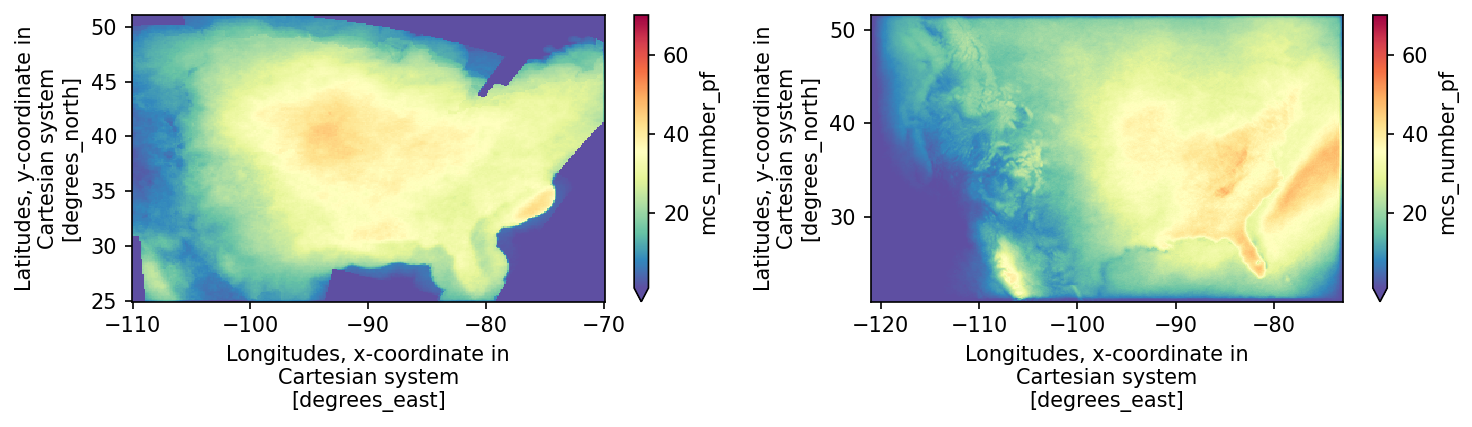

In [18]:
# Quick look plot
fig, ax = plt.subplots(ncols=2, figsize=[10,3], dpi=150)
mcs_number_pf_all_obs.plot(vmin=1, vmax=70, cmap='Spectral_r', ax=ax[0])
mcs_number_pf_all_wrf.plot(vmin=1, vmax=70, cmap='Spectral_r', ax=ax[1])
#mcs_number_pf_all_diff.plot(vmin=-50, vmax=50, cmap='RdBu', ax=ax[2])
fig.tight_layout()

# Plotting Function

In [19]:
def plot_map_ncol(ncol, dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, 
                  oob_colors=None, figsize=None, fontsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [-110, -70, 25, 50]
    proj = ccrs.PlateCarree()
    levelshgt = [1000, 6000]
    resolution = '50m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)

    fig = plt.figure(figsize=figsize, constrained_layout=False, dpi=150)
    gs = fig.add_gridspec(1, ncol, wspace=0.1, hspace=0)
    
    # Loop over each column
    for col in range(0, ncol):
        # ax = plt.subplot(1, 2, col+1, projection=proj)
        ax = plt.subplot(gs[col], projection=proj)
        lon = lonarray[col]
        lat = latarray[col]
        # Set map projection
        ax.set_extent(map_extend, crs=proj)
        ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
        ax.add_feature(states, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_aspect('auto', adjustable=None)
        # Set up grid lines and labels
        gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
        gl.right_labels = False
        gl.top_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()        
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        # if (col > 0):
        #     gl.left_labels = False

        # Plot title
        ax.set_title(titles[col], loc='left')
        data = dataarray[col]
        # Mask invalid data
#         Zm = np.ma.masked_where(((data == 0) | (np.isnan(data))), data)
        Zm = np.ma.masked_where(((np.isnan(data))), data)
        # Normalize colormap by discrete levels
        # cmap = copy.copy(mpl.cm.get_cmap(cmaps[col]))
        cmap = copy.copy(mpl.colormaps.get_cmap(cmaps[col]))
        norm = mpl.colors.BoundaryNorm(boundaries=levels[col], ncolors=cmap.N)
        cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=proj, zorder=2)
        # Set out-of-bounds colors
        if (oob_colors is not None) and (col != 2):
            cf1.cmap.set_over(oob_colors['over'])
            cf1.cmap.set_under(oob_colors['under'])
            cf1.set_clim(min(levels[col]), max(levels[col]))
        # Plot colorbar
        cb1 = plt.colorbar(cf1, ax=ax, label=cblabels[col], pad=0.02, ticks=cbticks[col], extend='both', aspect=30)

        # # Terrain height
        # ct = ax.contour(lon_ter, lat_ter, ter, levels=levelshgt, \
        #                 colors='dimgray', linewidths=1, transform=proj, zorder=3)

    # Work around to make tight_layout work 
    # fig.canvas.draw()
    # fig.tight_layout(w_pad=0.15)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [20]:
years = f'{start_year}-{end_year}'
years

'2004-2016'

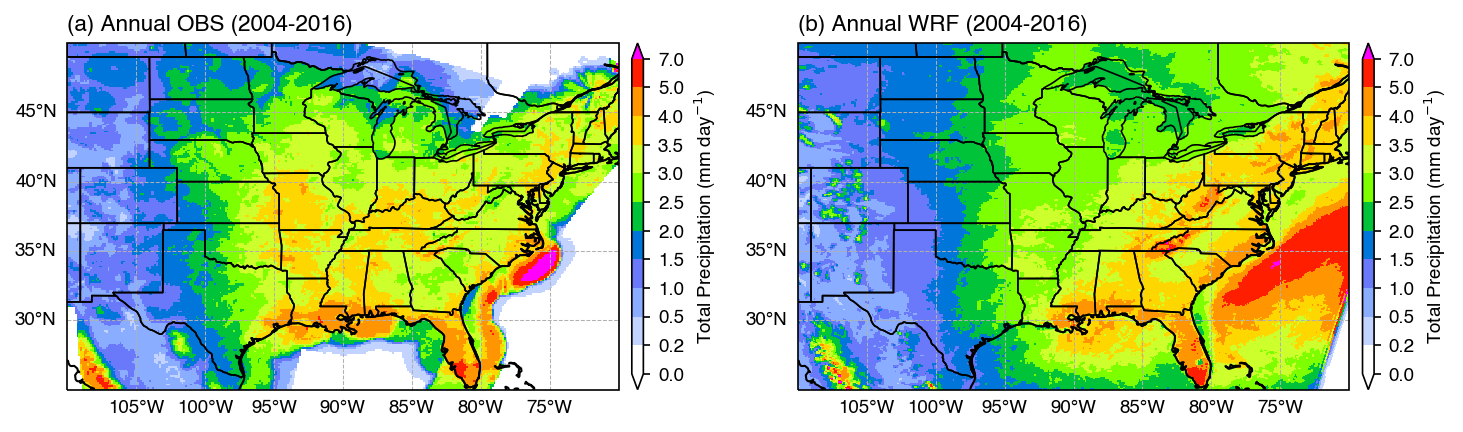

In [21]:
dataarray = [totpcp_all_obs, totpcp_all_wrf]
lonarray = [lon_obs, lon_wrf]
latarray = [lat_obs, lat_wrf]
levelspcp = [0,0.2,0.5,1,1.5,2,2.5,3,3.5,4,5,7]
levels = [levelspcp, levelspcp]
cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=17, cont_param_ws='sRGB')
cmaps = [cmappcp,cmappcp]
titles = [f'(a) Annual OBS ({years})', f'(b) Annual WRF ({years})']
cblabels = ['Total Precipitation (mm day$^{-1}$)','Total Precipitation (mm day$^{-1}$)']
cbticks = levels
figname = f'{figdir}obs_wrf_total_rainmap_annual_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_ncol(2, dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, 
                    oob_colors=oob_colors, figsize=[12,3.], fontsize=9)

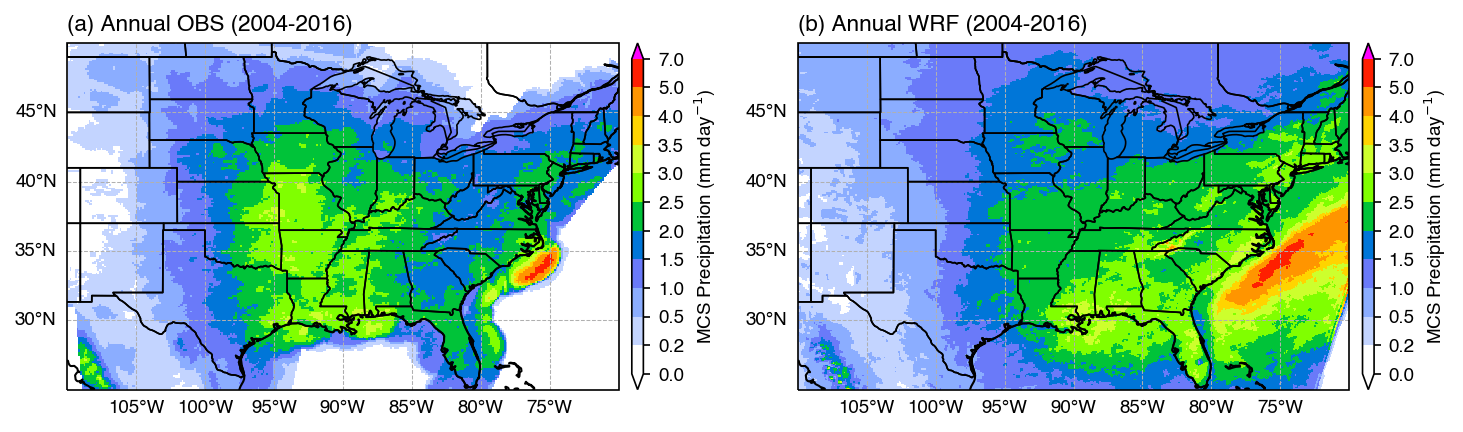

In [22]:
dataarray = [mcspcp_all_obs, mcspcp_all_wrf]
lonarray = [lon_obs, lon_wrf]
latarray = [lat_obs, lat_wrf]
levelspcp = [0,0.2,0.5,1,1.5,2,2.5,3,3.5,4,5,7]
levels = [levelspcp, levelspcp]
cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmaps = [cmappcp,cmappcp]
titles = [f'(a) Annual OBS ({years})', f'(b) Annual WRF ({years})']
cblabels = ['MCS Precipitation (mm day$^{-1}$)', 'MCS Precipitation (mm day$^{-1}$)']
cbticks = levels
figname = f'{figdir}obs_wrf_mcs_rainmap_annual_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_ncol(2, dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, 
                    oob_colors=oob_colors, figsize=[12,3.], fontsize=9)

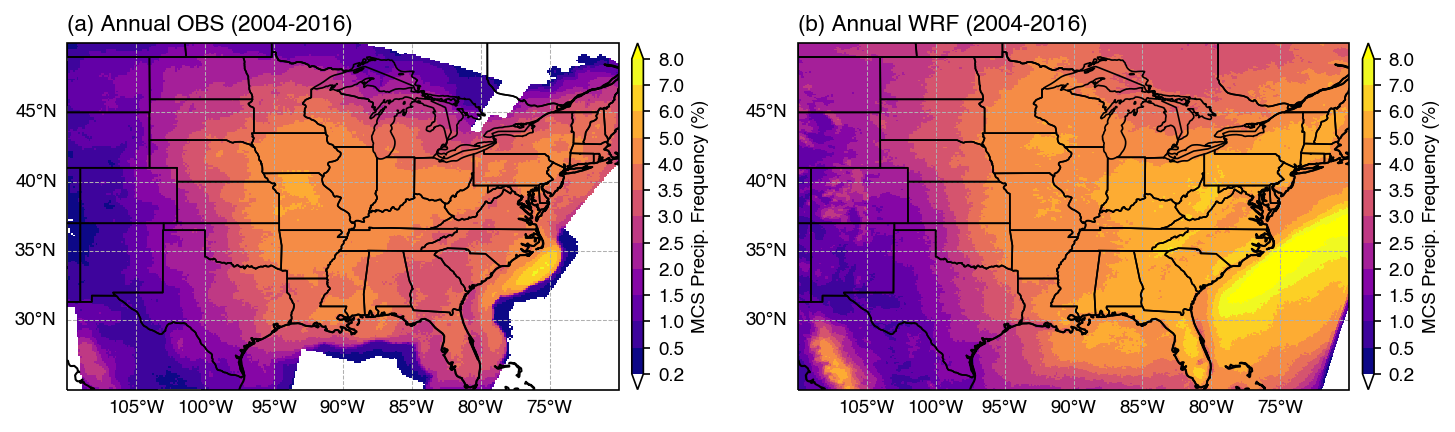

In [23]:
dataarray = [mcspcpfreq_all_obs, mcspcpfreq_all_wrf]
lonarray = [lon_obs, lon_wrf]
latarray = [lat_obs, lat_wrf]
levelsfreq = [0.2,0.5,1,1.5,2,2.5,3,3.5,4,5,6,7,8]
levels = [levelsfreq, levelsfreq]
cmapfreq = 'plasma'
cmaps = [cmapfreq,cmapfreq]
titles = [f'(a) Annual OBS ({years})', f'(b) Annual WRF ({years})']
cblabels = ['MCS Precip. Frequency (%)', 'MCS Precip. Frequency (%)']
cbticks = levels
figname = f'{figdir}obs_wrf_mcs_rainfreq_annual_{years}.png'
oob_colors = {'under':'white', 'over':'yellow'}
fig = plot_map_ncol(2, dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, 
                    oob_colors=oob_colors, figsize=[12,3.], fontsize=9)

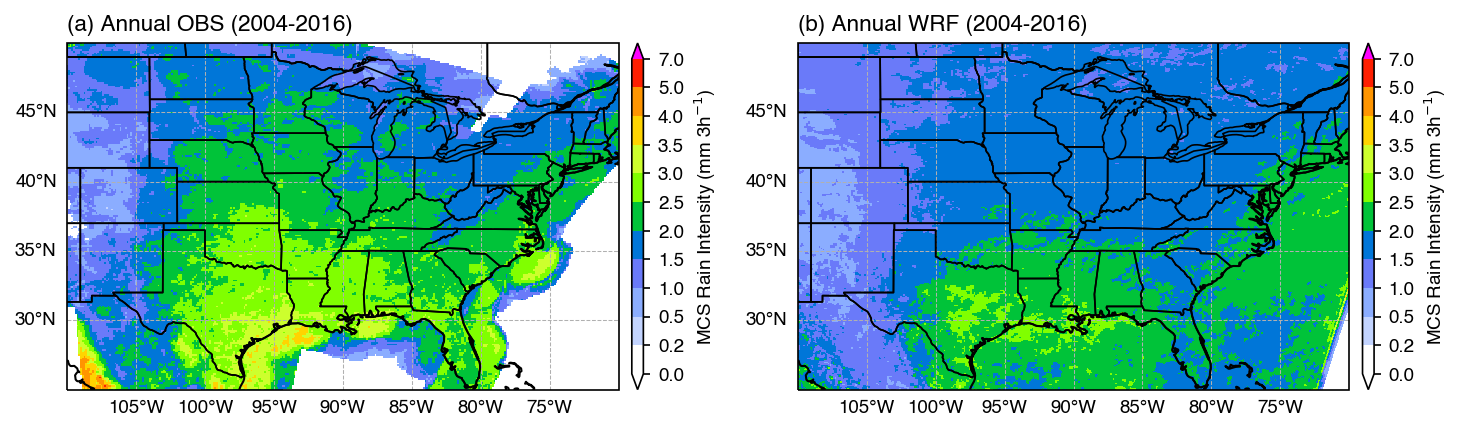

In [24]:
min_nmcs = 3
dataarray = [mcspcpintensity_all_obs.where(mcs_number_pf_all_obs > min_nmcs), 
             mcspcpintensity_all_wrf.where(mcs_number_pf_all_wrf > min_nmcs)]
lonarray = [lon_obs, lon_wrf]
latarray = [lat_obs, lat_wrf]
levels = [levelspcp, levelspcp]
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmaps = [cmap,cmap]
titles = [f'(a) Annual OBS ({years})', f'(b) Annual WRF ({years})']
cblabels = ['MCS Rain Intensity (mm 3h$^{-1}$)', 'MCS Rain Intensity (mm 3h$^{-1}$)']
cbticks = levels
figname = f'{figdir}obs_wrf_mcs_rainintensity_annual_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_ncol(2, dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, 
                    oob_colors=oob_colors, figsize=[12,3.], fontsize=9)

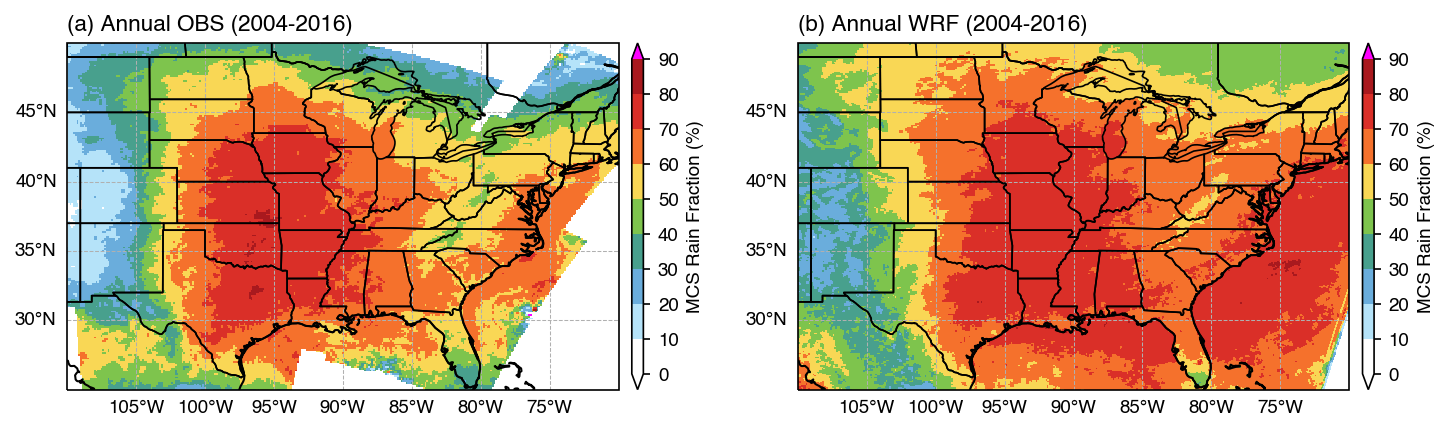

In [25]:
dataarray = [mcspcpfrac_all_obs, mcspcpfrac_all_wrf]
lonarray = [lon_obs, lon_wrf]
latarray = [lat_obs, lat_wrf]
levelsfrac = np.arange(0,91,10)
levels = [levelsfrac, levelsfrac]
cmap = generate_NCL_cmap('WhiteBlueGreenYellowRed', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', white_first=True, white_ext=True)
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmaps = [cmap,cmap,]
titles = [f'(a) Annual OBS ({years})', f'(b) Annual WRF ({years})']
cblabels = ['MCS Rain Fraction (%)', 'MCS Rain Fraction (%)']
cbticks = levels
figname = f'{figdir}obs_wrf_mcs_rainfrac_annual_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_ncol(2, dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, 
                    oob_colors=oob_colors, figsize=[12,3.], fontsize=9)

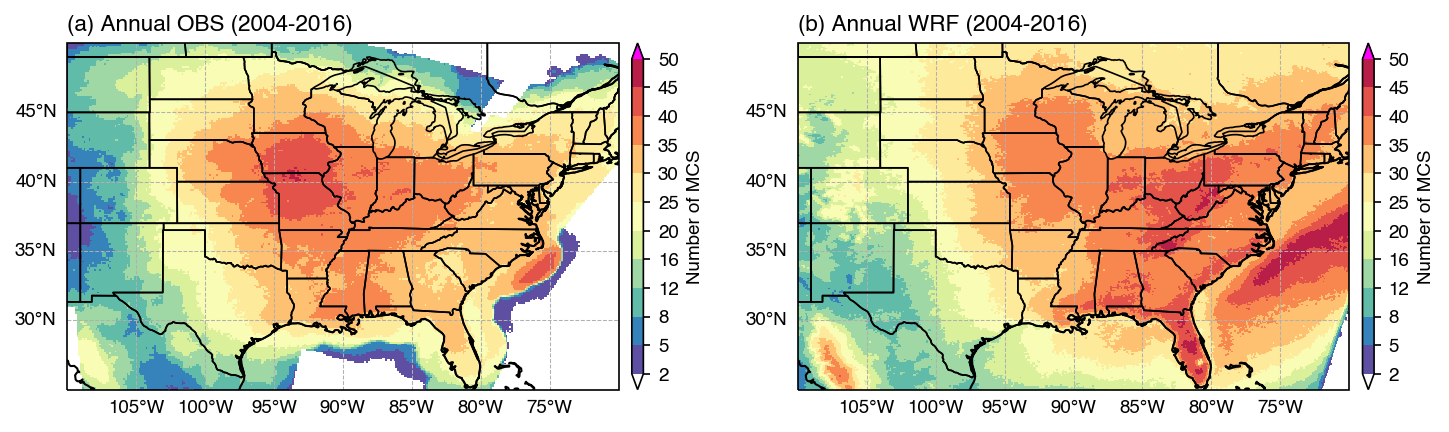

In [26]:
dataarray = [mcs_number_pf_all_obs, mcs_number_pf_all_wrf]
lonarray = [lon_obs, lon_wrf]
latarray = [lat_obs, lat_wrf]
levels = [2,5,8,12,16,20,25,30,35,40,45,50]
levels = [levels, levels]
# cmap = copy.copy(mpl.cm.get_cmap('Spectral_r'))
cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmaps = [cmap,cmap]
titles = [f'(a) Annual OBS ({years})', f'(b) Annual WRF ({years})']
cblabels = ['Number of MCS','Number of MCS']
cbticks = levels
figname = f'{figdir}obs_wrf_mcs_number_annual_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_ncol(2, dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, 
                    oob_colors=oob_colors, figsize=[12,3.], fontsize=9)

# Plot seasonal means to files (does not show in Notebook)

In [27]:
# Plot seasonal MCS rainmap
for ii in seasons:
    dataarray = [mcspcp_season_obs.sel(season=ii), mcspcp_season_wrf.sel(season=ii)]
    lonarray = [lon_obs, lon_wrf]
    latarray = [lat_obs, lat_wrf]
    levels = [0,0.2,0.5,1,1.5,2,2.5,3,3.5,4,5]
    levels = [levels, levels]
    cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
    cmaps = [cmap,cmap]
    titles = [f'(a) {ii} OBS ({years})', f'(b) {ii} WRF ({years})']
    cblabels = ['MCS Precipitation (mm day$^{-1}$)','MCS Precipitation (mm day$^{-1}$)']
    cbticks = levels
    figname = f'{figdir}obs_wrf_mcs_rainmap_{ii}_{years}.png'
    oob_colors = {'under':'white', 'over':'magenta'}
    fig = plot_map_ncol(2, dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, 
                    oob_colors=oob_colors, figsize=[12,3.], fontsize=9)
    plt.close(fig)
    print(f'{ii}: {figname}')

JJA: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_rainmap_JJA_2004-2016.png
MAM: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_rainmap_MAM_2004-2016.png
SON: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_rainmap_SON_2004-2016.png


In [28]:
for ii in seasons:
    dataarray = [mcspcpfreq_season_obs.sel(season=ii), mcspcpfreq_season_wrf.sel(season=ii)]
    lonarray = [lon_obs, lon_wrf]
    latarray = [lat_obs, lat_wrf]
    levelsfreq = [0.2,0.5,1,1.5,2,2.5,3,3.5,4,5,6,7,8]
    levels = [levelsfreq, levelsfreq]
    cmapfreq = 'plasma'
    cmaps = [cmapfreq, cmapfreq]
    titles = [f'(a) {ii} OBS ({years})', f'(b) {ii} WRF ({years})']
    cblabels = ['MCS Precip. Frequency (%)', 'MCS Precip. Frequency (%)']
    cbticks = levels
    figname = f'{figdir}obs_wrf_mcs_rainfreq_{ii}_{years}.png'
    oob_colors = {'under':'white', 'over':'yellow'}
    fig = plot_map_ncol(2, dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, 
                    oob_colors=oob_colors, figsize=[12,3.], fontsize=9)
    plt.close(fig)
    print(f'{ii}: {figname}')

JJA: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_rainfreq_JJA_2004-2016.png
MAM: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_rainfreq_MAM_2004-2016.png
SON: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_rainfreq_SON_2004-2016.png


In [29]:
for ii in seasons:
    min_nmcs = 2
    dataarray = [mcspcpintensity_season_obs.sel(season=ii).where(mcs_number_pf_season_obs.sel(season=ii) > min_nmcs), 
                 mcspcpintensity_season_wrf.sel(season=ii).where(mcs_number_pf_season_wrf.sel(season=ii) > min_nmcs)]
    lonarray = [lon_obs, lon_wrf]
    latarray = [lat_obs, lat_wrf]
    levelspcp = [0.1,0.4,0.7,1.0,1.4,1.8,2.2,2.6,3,3.5,4]
    levels = [levelspcp, levelspcp]
    cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
    cmaps = [cmap,cmap]
    titles = [f'(a) {ii} OBS ({years})', f'(b) {ii} WRF ({years})']
    cblabels = ['MCS Rain Intensity (mm 3h$^{-1}$)','MCS Rain Intensity (mm 3h$^{-1}$)']
    cbticks = levels
    figname = f'{figdir}obs_wrf_mcs_rainintensity_{ii}_{years}.png'
    oob_colors = {'under':'white', 'over':'magenta'}
    fig = plot_map_ncol(2, dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, 
                    oob_colors=oob_colors, figsize=[12,3.], fontsize=9)
    plt.close(fig)
    print(f'{ii}: {figname}')

JJA: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_rainintensity_JJA_2004-2016.png
MAM: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_rainintensity_MAM_2004-2016.png
SON: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_rainintensity_SON_2004-2016.png


In [30]:
for ii in seasons:
    dataarray = [mcspcpfrac_season_obs.sel(season=ii), mcspcpfrac_season_wrf.sel(season=ii)]
    lonarray = [lon_obs, lon_wrf]
    latarray = [lat_obs, lat_wrf]
    levelsfrac = np.arange(0,91,10)
    levels = [levelsfrac, levelsfrac]
    cmap = generate_NCL_cmap('WhiteBlueGreenYellowRed', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', white_first=True, white_ext=True)
    cmap = truncate_colormap(cmap, 0.0, 0.95)
    cmaps = [cmap, cmap,]
    titles = [f'(a) {ii} OBS ({years})', f'(b) {ii} WRF ({years})']
    cblabels = ['MCS Rain Fraction (%)', 'MCS Rain Fraction (%)']
    cbticks = levels
    figname = f'{figdir}obs_wrf_mcs_rainfrac_{ii}_{years}.png'
    oob_colors = {'under':'white', 'over':'magenta'}
    fig = plot_map_ncol(2, dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, 
                    oob_colors=oob_colors, figsize=[12,3.], fontsize=9)
    plt.close(fig)
    print(f'{ii}: {figname}')

JJA: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_rainfrac_JJA_2004-2016.png
MAM: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_rainfrac_MAM_2004-2016.png
SON: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_rainfrac_SON_2004-2016.png


In [31]:
for ii in seasons:
    dataarray = [mcs_number_pf_season_obs.sel(season=ii), mcs_number_pf_season_wrf.sel(season=ii)]
    lonarray = [lon_obs, lon_wrf]
    latarray = [lat_obs, lat_wrf]
    levels = [2,4,6,8,10,12,15,18,21,25,30]
    levels = [levels, levels]
    # cmap = copy.copy(mpl.cm.get_cmap('Spectral_r'))
    cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
    
    cmap = truncate_colormap(cmap, 0.0, 0.95)
    cmaps = [cmap,cmap]
    titles = [f'(a) {ii} OBS ({years})', f'(b) {ii} WRF ({years})']
    cblabels = ['Number of MCS', 'Number of MCS']
    cbticks = levels
    figname = f'{figdir}obs_wrf_mcs_number_{ii}_{years}.png'
    oob_colors = {'under':'white', 'over':'magenta'}
    fig = plot_map_ncol(2, dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, 
                    oob_colors=oob_colors, figsize=[12,3.], fontsize=9)
    plt.close(fig)
    print(f'{ii}: {figname}')

JJA: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_number_JJA_2004-2016.png
MAM: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_number_MAM_2004-2016.png
SON: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/obs_wrf_mcs_number_SON_2004-2016.png


In [32]:
figdir

'/global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/'